# Sound Detection

Sound detection using `tensorflow`.

Reference: [tensor flow guide on audio detection](https://www.tensorflow.org/tutorials/audio/simple_audio)


## Setup

In [1]:
import os
import pathlib
import math

import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
# Set the seed value for experiment reproducibility.
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

## Data

In [3]:
CWD = pathlib.Path(os.getcwd())
DS_PATH = os.path.join(CWD.parent, 'data')

data_dir = pathlib.Path(DS_PATH)

Sampling rate = 22050. Longest duration = 18.


''

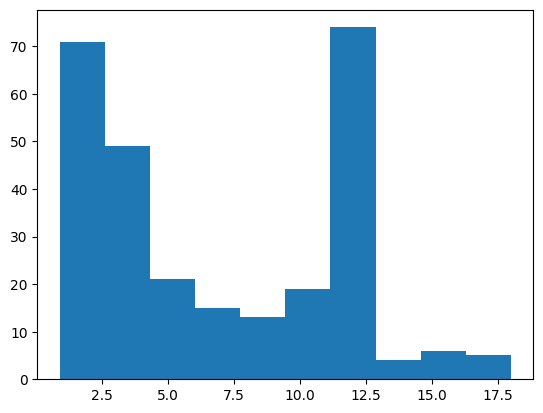

In [4]:
# Check sampling rate and durations.
sr_found = []
durations = []
for f in data_dir.glob("*.wav"):
    y, sr = librosa.load(f)
    if sr not in sr_found:
        sr_found.append(sr)
    durations.append(librosa.get_duration(y=y))
SR = None
if len(sr_found) == 1:
    SR = sr_found[0]
else:
    raise Exception("Multiple sampling rates found.")
max_duration = math.ceil(max(durations))
print(f"Sampling rate = {SR}. Longest duration = {max_duration}.")
plt.hist(durations)
;

In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=8,
    validation_split=0.2,
    seed=seed,
    output_sequence_length=max_duration*SR,
    subset='both',
    labels='inferred'
)
label_names = np.array(train_ds.class_names)
print("Label names:", label_names)

# librosa loads audio as mono by default. Use squeeze to drop extra axis.
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
print("Element spec:", train_ds.element_spec)

Found 277 files belonging to 2 classes.
Using 222 files for training.
Using 55 files for validation.
Label names: ['cats' 'dogs']
Element spec: (TensorSpec(shape=(None, 396900), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [6]:
# Create a test set
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [7]:
# Utlity function to convert wave data to spectograms
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

# Function to show the spectograms
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [8]:
# Look at data
for example_audio, example_labels in train_ds.take(1):  
    print(f'Audio shape = {example_audio.shape}')
    print(f'Label shape = {example_labels.shape}')
for i in range(1):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)

Audio shape = (8, 396900)
Label shape = (8,)
Label: cats
Waveform shape: (396900,)
Spectrogram shape: (3099, 129, 1)


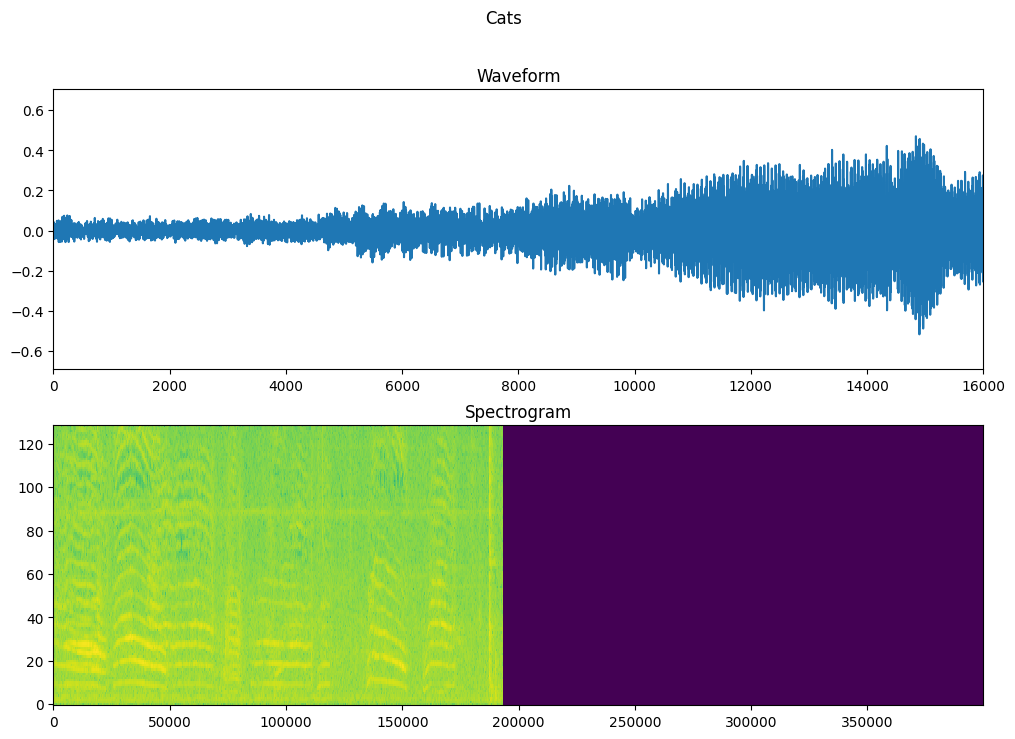

In [9]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [10]:
# Create a spectogram ds
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Model

In [11]:
# Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [12]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break   
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [14]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
28/28 [==============================] - 2s 57ms/step - loss: 0.6230 - accuracy: 0.7207 - val_loss: 0.3740 - val_accuracy: 0.9167
Epoch 2/10
28/28 [==============================] - 1s 36ms/step - loss: 0.4132 - accuracy: 0.8514 - val_loss: 0.3813 - val_accuracy: 0.7500
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.3173 - accuracy: 0.8423 - val_loss: 0.2748 - val_accuracy: 0.9167
Epoch 4/10
28/28 [==============================] - 1s 37ms/step - loss: 0.2206 - accuracy: 0.9234 - val_loss: 0.2500 - val_accuracy: 0.9167
Epoch 5/10
28/28 [==============================] - 1s 40ms/step - loss: 0.1919 - accuracy: 0.9234 - val_loss: 0.3133 - val_accuracy: 0.9167
Epoch 6/10
28/28 [==============================] - 1s 45ms/step - loss: 0.1564 - accuracy: 0.9775 - val_loss: 0.2512 - val_accuracy: 0.9167
Epoch 6: early stopping


## Metrics

Text(0, 0.5, 'Accuracy [%]')

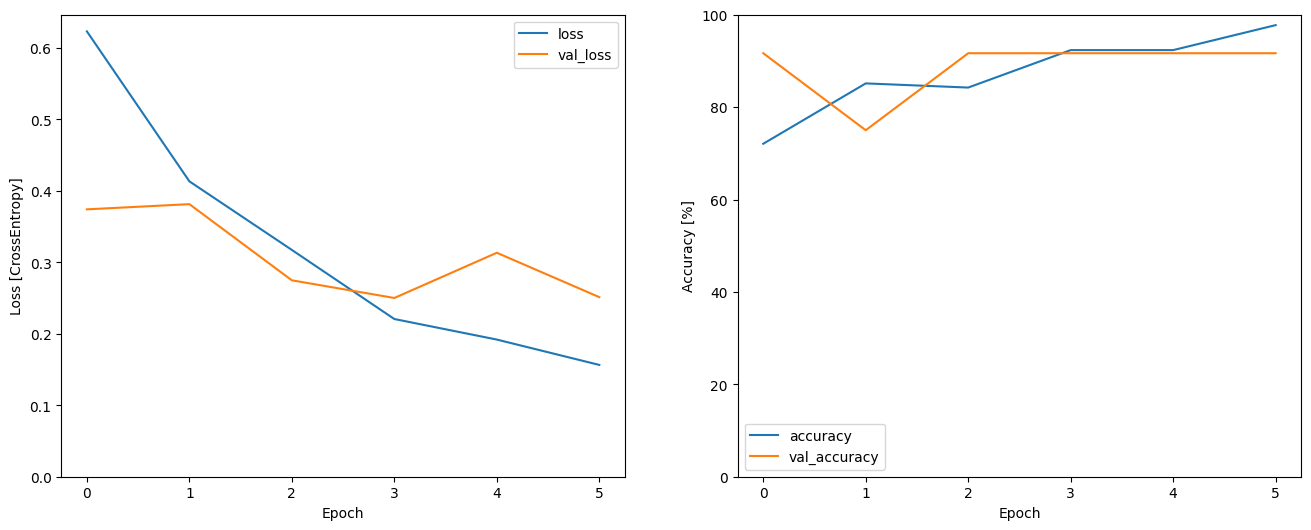

In [15]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

4/4 [==============================] - 0s 6ms/step


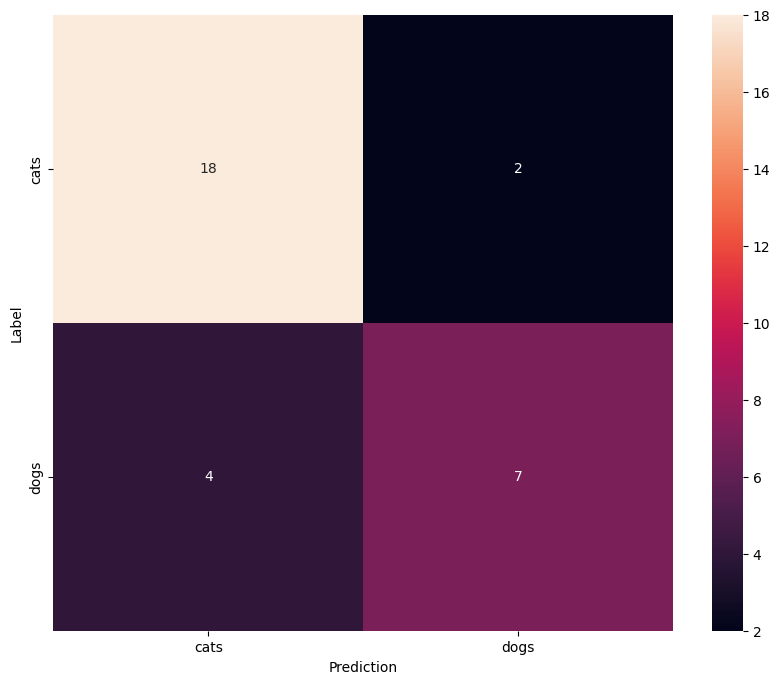

In [16]:
model.evaluate(test_spectrogram_ds, return_dict=True)

y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()